# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
    ### STUDENT START ###
    for i in range(num_examples):
        print("\nExample", i+1, "\nLabel:", train_labels[i], 
              "\nTopic:", newsgroups_train.target_names[train_labels[i]],
              "\nMessage:", train_data[i])
    ### STUDENT END ###

P1(5)


Example 1 
Label: 1 
Topic: comp.graphics 
Message: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Example 2 
Label: 3 
Topic: talk.religion.misc 
Message: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been 

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [4]:
def P2():
    ### STUDENT START ###
    # word unigram feature vectorizer
    vectorizer = CountVectorizer()
    matrix = vectorizer.fit_transform(train_data)
    feature_names = vectorizer.get_feature_names()
    print("The word unigram feature vectorizer:")
    print("Size of the vocabulary:", len(feature_names))
    print("Average number of non-zero features: %i" % (matrix.nnz / len(train_data)))
    print("Fraction of the non-zero entries: %.2f%%" % (100.0 * matrix.nnz / (matrix.shape[0] * matrix.shape[1])))
    print("The 0th feature string:", feature_names[0])
    print("The last feature string:", feature_names[len(feature_names)-1])
    
    # word unigram feature vectorizer with a vocabulary of 4 words
    vectorizer2 = CountVectorizer(vocabulary = ["atheism", "graphics", "space", "religion"])
    matrix2 = vectorizer2.fit_transform(train_data)
    feature_names2 = vectorizer2.get_feature_names()
    print("\nThe word unigram feature vectorizer with a vocabulary of 4 words:")
    print("Size of the vocabulary:", len(feature_names2))
    print("Average number of non-zero features: %.2f" % (matrix2.nnz / len(train_data)))
    
    # character bigram and trigram feature vectorizer
    char_vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (2, 3))
    cv_matrix = char_vectorizer.fit_transform(train_data)
    cv_feature_names = char_vectorizer.get_feature_names()
    print("\nThe character bigram and trigram feature vectorizer")
    print("Size of the vocabulary:", len(cv_feature_names))
    
    # create a word unigram feature vectorizer and prune words that appears in fewer than 10 docs
    mindf_vectorizer = CountVectorizer(min_df = 10)
    mindf_matrix = mindf_vectorizer.fit_transform(train_data)
    mindf_feature_names = mindf_vectorizer.get_feature_names()
    print("\nThe word unigram feature vectorizer with a minimum df of 10:")
    print("Size of the vocabulary:", len(mindf_feature_names))
    
    # word unigram feature vectorizer
    dev_matrix = vectorizer.fit_transform(dev_data)
    feature_names_dev = vectorizer.get_feature_names()
    
    # find words in training set but missing in dev set
    diff = set(feature_names_dev).difference(feature_names)
    print("\nUsing the original word unigram feature vectorizer:")
    print("Size of the difference between training and development vocabularies: ", len(diff))
    print("Fraction of words in the development vocabulary that is missing from the training vocabulary: %.2f%%" %
          (len(diff) / len(feature_names_dev)*100))
    ### STUDENT END ###

P2()

The word unigram feature vectorizer:
Size of the vocabulary: 26879
Average number of non-zero features: 96
Fraction of the non-zero entries: 0.36%
The 0th feature string: 00
The last feature string: zyxel

The word unigram feature vectorizer with a vocabulary of 4 words:
Size of the vocabulary: 4
Average number of non-zero features: 0.27

The character bigram and trigram feature vectorizer
Size of the vocabulary: 35478

The word unigram feature vectorizer with a minimum df of 10:
Size of the vocabulary: 3064

Using the original word unigram feature vectorizer:
Size of the difference between training and development vocabularies:  4027
Fraction of words in the development vocabulary that is missing from the training vocabulary: 24.79%


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def P3():
    ### STUDENT START ###
    vectorizer = CountVectorizer()
    matrix = vectorizer.fit_transform(train_data)
    dev_matrix = vectorizer.transform(dev_data)
    
    # 1) KNN models
    k_values = [1, 3, 5, 7, 9, 11, 15, 17, 20, 23, 25, 27, 30]
    for k in k_values:
        KNN_model = KNeighborsClassifier(n_neighbors = k)
        KNN_model.fit(matrix, train_labels)
        print("F1-score for %i-NN classifier model is %.4f." % 
              (k, metrics.f1_score(dev_labels, KNN_model.predict(dev_matrix), average='weighted')))
    
    # 2) Naive Bayes models
    alpha_values = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    for alpha in alpha_values:
        MNB_model = MultinomialNB(alpha = alpha)
        MNB_model.fit(matrix, train_labels)
        print("F1-score for Multinomial Naive Bayes model with alpha %r is %.4f." % 
              (alpha, metrics.f1_score(dev_labels, MNB_model.predict(dev_matrix), average='weighted')))
    
    # 3) Logistics regression models
    C_values = [0.001, 0.01, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0, 100.0]
    for C in C_values:
        LogReg_model = LogisticRegression(C = C, solver = "liblinear", multi_class="auto")
        LogReg_model.fit(matrix, train_labels)
        print("\nF1-score for Logistic Regression Model with C = %r is %.4f;" % 
              (C, metrics.f1_score(dev_labels, LogReg_model.predict(dev_matrix), average='weighted')))
        print("and sum of squared weights for each topic is: ", np.sum(LogReg_model.coef_**2, axis = 1))
    ### STUDENT END ###

P3()

F1-score for 1-NN classifier model is 0.3805.
F1-score for 3-NN classifier model is 0.4084.
F1-score for 5-NN classifier model is 0.4288.
F1-score for 7-NN classifier model is 0.4505.
F1-score for 9-NN classifier model is 0.4366.
F1-score for 11-NN classifier model is 0.4266.
F1-score for 15-NN classifier model is 0.4326.
F1-score for 17-NN classifier model is 0.4486.
F1-score for 20-NN classifier model is 0.4243.
F1-score for 23-NN classifier model is 0.4081.
F1-score for 25-NN classifier model is 0.4161.
F1-score for 27-NN classifier model is 0.4245.
F1-score for 30-NN classifier model is 0.4319.
F1-score for Multinomial Naive Bayes model with alpha 1e-10 is 0.7472.
F1-score for Multinomial Naive Bayes model with alpha 0.0001 is 0.7628.
F1-score for Multinomial Naive Bayes model with alpha 0.001 is 0.7703.
F1-score for Multinomial Naive Bayes model with alpha 0.01 is 0.7752.
F1-score for Multinomial Naive Bayes model with alpha 0.1 is 0.7903.
F1-score for Multinomial Naive Bayes mode

**ANSWER:**

**1) The optimal model is 7-NN Model which has a F1 score of 0.4505.**

**2) The optimal Multinomial Naive Bayes model uses alpha 0.1 and has a F1 score of 0.7903.**

**3) The optimal Logistic regression model uses a L2 regularization strength of 0.5 and has a F1 score of 0.7085.**

**4) K-NN model does not work well for this problem because of three reasons:**

    - The accuracy of KNN model may suffer from mismatch of class distribution in the dev data set vs the training data set. If a certain class shows up very frequently in the training set, it could dominate the majority voting of the new example. If this class appears much less frequently in the dev set, the model's accuracy will be suffered.
    
    - The accuracy of KNN model can be suffered from curse of dimensionality. If the dimensionality of the space is large, the distance metrics lose some meaning as there is little difference between the nearest and farthest neighbor.
    
    - There may be many words overlapping among classes. This issue could detriment the distance metircs which KNN-model replies on for prediction
    
**5) Logistics regression does not work well when the number of observations are less than the number of features. It may perform better than Naive Bayes model if the sample is larger.**

**6) C-value is the inverse of regularization strength. A small C-value means a strong regularization strength and hence a small sum of squared weights. When C-value increases, the sum of squared weights for each topic increases as well.**

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [6]:
def P4():
    ### STUDENT START ###
    bigram_vectorizer = CountVectorizer(ngram_range = (2, 2))
    train_matrix = bigram_vectorizer.fit_transform(train_data)
    dev_matrix = bigram_vectorizer.transform(dev_data)
    feature_names = np.array(bigram_vectorizer.get_feature_names())
    
    LogReg_model = LogisticRegression(C = 0.5, solver = "liblinear", multi_class="auto")
    LogReg_model.fit(train_matrix, train_labels)
    indices = np.argsort(LogReg_model.coef_, axis = 1)   #absolute or largest positive?
    num_class = np.shape(LogReg_model.coef_)[0]
    
    # Top 5 features with the largest weights
    top5features = np.empty(num_class*5, dtype= 'object')
    weights = np.empty([20, num_class])
    
    for i in range(num_class):
        print(newsgroups_train.target_names[i])
        for j, index in enumerate(indices[i, -5:]):
            top5features[i*5+j] = feature_names[index]
            weights[i*5+j,:] = np.transpose(np.round(LogReg_model.coef_[:, index], 5))
        print(top5features[i*5:i*5+5])
    
    row_format = "{:>20}" * (num_class + 1)
    print(row_format.format("", *newsgroups_train.target_names))
    for feature_name, weight in zip(top5features, weights):
        print(row_format.format(feature_name, *weight))
    
    ### STUDENT END ###

P4()

alt.atheism
['are you' 'you are' 'was just' 'cheers kent' 'claim that']
comp.graphics
['is there' 'out there' 'comp graphics' 'in advance' 'looking for']
sci.space
['it was' 'and such' 'sci space' 'the moon' 'the space']
talk.religion.misc
['of jesus' 'but he' 'ignorance is' 'cheers kent' 'the fbi']
                             alt.atheism       comp.graphics           sci.space  talk.religion.misc
             are you             0.44695            -0.24826            -0.09713            -0.30562
             you are             0.47274            -0.27991            -0.48131             0.02838
            was just             0.48205            -0.13142            -0.12891            -0.22746
         cheers kent             0.55572            -0.69791            -0.66376             0.53481
          claim that             0.60555            -0.19904            -0.27434            -0.14037
            is there            -0.34088             0.75498            -0.46824            -

ANSWER:

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [7]:
# stopWords = ['and', 'hers', 'but', 'again', 'there', 'about', 'once', 
#                'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 
#                'its', 'yours', 'such', 'into', 'of', 'most', 'other', 'off', 'is', 's', 'am', 'or',
#                'who', 'as', 'from', 'him', 'each', 'the', 'until', 'below', 'are', 'we', 'these',
#                'your', 'his', 'don', 'nor', 'me', 'were', 'her', 'more', 'this', 'down',
#                'should', 'our', 'their', 'while', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 
#                'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 
#                'does', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 
#                'not', 'now', 'he', 'you', 'has', 'just', 'where', 'too', 'only',
#                'which', 'those', 'i', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 
#                'a', 'by', 'doing', 'it', 'how', 'was', 'here', 'than']
#     stopWords = ['ourselves', 'and', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 
#                'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 
#                'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or',
#                'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these',
#                'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down',
#                'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 
#                'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 
#                'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 
#                'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself',
#                'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 
#                'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
    
#         stopWords = ['and', 'hers', 'between', 'but', 'again', 'there', 'about', 'once', 
#                'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 
#                'its', 'yours', 'such', 'into', 'of', 'most', 'other', 'off', 'is', 's', 'am', 'or',
#                'who', 'as', 'from', 'him', 'each', 'the', 'until', 'below', 'are', 'we', 'these',
#                'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down',
#                'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 
#                'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 
#                'does', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 
#                'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only',
#                'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 
#                'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']

In [8]:
def better_preprocessor(s):
    ### STUDENT START ###
    
    new_s = s.lower()
    new_s = re.sub(r"[^a-z]", " ", new_s)

    stopWords = ['and', 'hers', 'between', 'but', 'again', 'there', 'about', 'once', 
               'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 
               'its', 'yours', 'such', 'into', 'of', 'most', 'other', 'off', 'is', 's', 'am', 'or',
               'who', 'as', 'from', 'him', 'each', 'the', 'until', 'below', 'are', 'we', 'these',
               'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down',
               'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 
               'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 
               'does', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 
               'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only',
               'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 
               'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
    new_s = " ".join([word for word in new_s.split() if word not in stopWords])
    #new_s = re.sub(r"\b[\w']{1,2}\b", " ",new_s)
    #new_s = re.sub(r"\s{2,}", " ", new_s)
    
    truncated_s = ""
    for word in new_s.split():
        #word = re.sub("s$", "", word)
        #word = re.sub("ing$", "", word)
        #word = re.sub("ed$", "", word)
        #word = re.sub("ion$", "", word)
        if len(word) > 6:
            word = word[:6]
        truncated_s += word + " "

    return truncated_s
    ### STUDENT END ###
#text = "There is a Lot 325 2 S2anded sands ed landed"
#print(better_preprocessor(text))
def P5():
    ### STUDENT START ###
    vectorizer = CountVectorizer()
    train_matrix = vectorizer.fit_transform(train_data)
    dev_matrix = vectorizer.transform(dev_data)
    feature_names = np.array(vectorizer.get_feature_names())
    
    LogReg_model = LogisticRegression(C = 0.5, solver = "liblinear", multi_class="auto")
    LogReg_model.fit(train_matrix, train_labels)
    print("Vocabulary size: ", len(feature_names))
    print("F1-score is %.4f." % metrics.f1_score(dev_labels, LogReg_model.predict(dev_matrix), average='weighted'))
    
    
    vectorizer = CountVectorizer(preprocessor=better_preprocessor)
    train_matrix = vectorizer.fit_transform(train_data)
    dev_matrix = vectorizer.transform(dev_data)
    feature_names = np.array(vectorizer.get_feature_names())
    
    LogReg_model = LogisticRegression(C = 0.5, solver = "liblinear", multi_class="auto")
    LogReg_model.fit(train_matrix, train_labels)
    print("Vocabulary size: ", len(feature_names))
    print("F1-score is %.4f." % metrics.f1_score(dev_labels, LogReg_model.predict(dev_matrix), average='weighted'))
    ### STUDENT END ###

P5()

Vocabulary size:  26879
F1-score is 0.7085.
Vocabulary size:  17356
F1-score is 0.7296.


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

C:\Users\Ambe Chen\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                   C     Vocabulary Size            Accuracy
               0.001                   3             0.33357
                0.01                  17             0.46385
                 0.5                 723             0.67769
                 1.0                1066             0.68616
                 2.0                2004             0.69121
                 5.0                2668             0.69314
                10.0                3364             0.70245
                50.0                6054             0.69806
               100.0                7816             0.68355


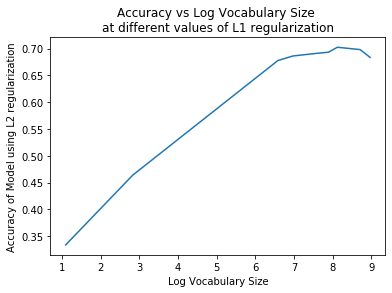

In [9]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    ### STUDENT START ###
    vectorizer = CountVectorizer()
    train_matrix = vectorizer.fit_transform(train_data)
    dev_matrix = vectorizer.transform(dev_data)
    feature_names = np.array(vectorizer.get_feature_names())
    
    C_l1_list = [0.001, 0.01, 0.5, 1.0, 2.0, 5.0, 10.0, 50.0, 100.0]
    accuracies = []
    vocab_sizes = []
    for c in C_l1_list:
        LogReg_L1 = LogisticRegression(C = c, solver = "liblinear", multi_class="auto", penalty = "l1", tol = 0.015)
        LogReg_L1.fit(train_matrix, train_labels)
        sumwgt_per_features = np.sum(LogReg_L1.coef_, axis = 0)
        nonzero_sum_wgt_idx = np.nonzero(sumwgt_per_features)
        reduced_vocab = feature_names[nonzero_sum_wgt_idx]

        vectorizer2 = CountVectorizer(vocabulary=reduced_vocab)
        train_matrix2 = vectorizer2.fit_transform(train_data)
        dev_matrix2 = vectorizer2.transform(dev_data)
        LogReg_L2 = LogisticRegression(C = 0.5, solver = "liblinear", multi_class="auto", penalty = "l2", tol = 0.015)
        LogReg_L2.fit(train_matrix2, train_labels)
        
        accuracies.append(metrics.f1_score(dev_labels, LogReg_L2.predict(dev_matrix2), average='weighted'))
        vocab_sizes.append(len(reduced_vocab))
        
    row_format = "{:>20}" * 3
    print(row_format.format("C", "Vocabulary Size", "Accuracy"))
    for c, size, accuracy in zip(C_l1_list, vocab_sizes, accuracies):
        print(row_format.format(c, size, np.round(accuracy,5)))
    
    plt.figure()
    plt.plot(np.log(vocab_sizes), accuracies)
    plt.xlabel("Log Vocabulary Size")
    plt.ylabel("Accuracy of Model using L2 regularization")
    plt.title("Accuracy vs Log Vocabulary Size \nat different values of L1 regularization")
    ### STUDENT END ###

P6()

ANSWER: Reduced vocabulary size is big enough, the accuracy performs similar to that of a model based on full vocabulary

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [37]:
def P7():
    ### STUDENT START ###
    vectorizer = TfidfVectorizer()
    train_matrix = vectorizer.fit_transform(train_data)
    dev_matrix = vectorizer.transform(dev_data)
    
    LogReg_model = LogisticRegression(C = 100, solver = "liblinear", multi_class="auto")
    LogReg_model.fit(train_matrix, train_labels)
    predict_prob = LogReg_model.predict_proba(dev_matrix)
    pred_prb_correct = np.zeros(len(dev_labels))
    for i, label in enumerate(dev_labels):
        pred_prb_correct[i] = predict_prob[i][label]
    R_ratio = predict_prob[:len(dev_labels), :].max(axis=1)/pred_prb_correct
    indices = np.argsort(R_ratio)
    
    largest_3 = np.transpose([R_ratio[indices[-3:len(indices)]],
                 predict_prob[indices[-3:len(indices)],:].max(axis=1),
                 np.argmax(predict_prob[indices[-3:len(indices)],:], axis=1),
                 dev_labels[indices[-3:len(indices)]]])

    for i in range(np.shape(largest_3)[0]):
        print("Top %i R ratio: %.5f" % (np.shape(largest_3)[0]-i, largest_3[i][0]))
        print("Class %s has the highest predicted probability of %.5f" %
              (newsgroups_train.target_names[int(largest_3[i][2])], largest_3[i][1]))
        print("The actual class label is", newsgroups_train.target_names[int(largest_3[i][3])])
    
    ### STUDENT END ###

    
P7()

Top 3 R ratio: 287.17945
Class talk.religion.misc has the highest predicted probability of 0.69546
The actual class label is alt.atheism
Top 2 R ratio: 325.00406
Class comp.graphics has the highest predicted probability of 0.97975
The actual class label is talk.religion.misc
Top 1 R ratio: 929.35758
Class comp.graphics has the highest predicted probability of 0.99372
The actual class label is talk.religion.misc


ANSWER:

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.